In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing Libraries

In [84]:
# Data Analysis
import pandas as pd
import numpy as np
from pandas import to_datetime

# Data Visualization
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
#importing for arima
from statsmodels.tsa.arima.model import ARIMA
#importing for sarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX
#importing for prophet
from prophet import Prophet


# Machine Learning
from sklearn.metrics import mean_squared_error

Data Reading
-----------------------------

In [85]:
# Reading the file
df = pd.read_csv('/content/drive/MyDrive/Datasets/100_THESIS_FINAL/Water Level/TDWL/Satkhira-Kholpetua.csv')
#the daily dataset
print(df.shape)
df.head()

(16512, 4)


,Date,Max_WL(m),Min_WL(m),WL(m)
0,1968-04-01,2.18,-1.49,0.345
1,1968-04-02,2.16,-1.48,0.340
2,1968-04-03,2.16,-1.43,0.365
3,1968-04-04,2.03,-1.33,0.350
4,1968-04-05,1.81,-1.08,0.365


In [86]:
#checking types
df.pop('Max_WL(m)')
df.pop('Min_WL(m)')
df.dtypes

Date      object
WL(m)    float64
dtype: object

Data Preprocessing
---------

In [87]:
# 1. Checking missing values
df.isnull().sum()
# 2.Dropping nulls
print(df.dropna())

             Date  WL(m)
0      1968-04-01  0.345
1      1968-04-02  0.340
2      1968-04-03  0.365
3      1968-04-04  0.350
4      1968-04-05  0.365
...           ...    ...
16507  2019-04-26  1.010
16508  2019-04-27  0.995
16509  2019-04-28  0.950
16510  2019-04-29  0.930
16511  2019-04-30  0.935

[16512 rows x 2 columns]


In [88]:
# 3.Check for duplicates
df.duplicated().sum()

0

In [89]:
df.head()

,Date,WL(m)
0,1968-04-01,0.345
1,1968-04-02,0.340
2,1968-04-03,0.365
3,1968-04-04,0.350
4,1968-04-05,0.365


In [90]:
df.tail()

,Date,WL(m)
16507,2019-04-26,1.010
16508,2019-04-27,0.995
16509,2019-04-28,0.950
16510,2019-04-29,0.930
16511,2019-04-30,0.935


In [91]:
# Preparing dataset for forecasting
df_pr = df
# 4.sorting dataset by date for forecast
df_pr.sort_values('Date', inplace=True)
# 5.setting the index by date after sorting
df_pr.set_index('Date', inplace=True)
df_pr.head()

,WL(m)
Date,
1968-04-01,0.345
1968-04-02,0.340
1968-04-03,0.365
1968-04-04,0.350
1968-04-05,0.365


In [92]:
# 6.Resampling dataset to monthly timeseries
df_pr.index = pd.to_datetime(df_pr.index)
monthly = df_pr.resample('M').mean()
print(monthly.shape)
monthly.head()
monthly.to_csv("Satkhira-Kholpetua_monthly.csv")

(613, 1)


In [93]:
# Understanding the data for TS
print(f'Start Date: {monthly.index.min()}')
print(f'End Date: {monthly.index.max()}')
print(f'Total month: {len(monthly)}')
print(f'Total year: {int(len(monthly.index)/12)}')

Start Date: 1968-04-30 00:00:00
End Date: 2019-04-30 00:00:00
Total month: 613
Total year: 51


Data Visulalization
----------

About Data

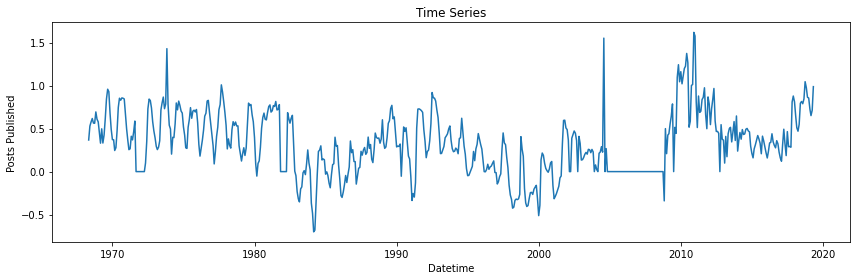

In [94]:
# 7.Plotting the time series
monthly['WL(m)'] = monthly['WL(m)'].fillna(0)
plt.figure(figsize=(12, 4))
plt.plot(monthly)
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('Time Series')
plt.tight_layout()
plt.show()

Splitting the Train & Test data for forecasting

Shape: Train=(501, 1), Validation=(112, 1)


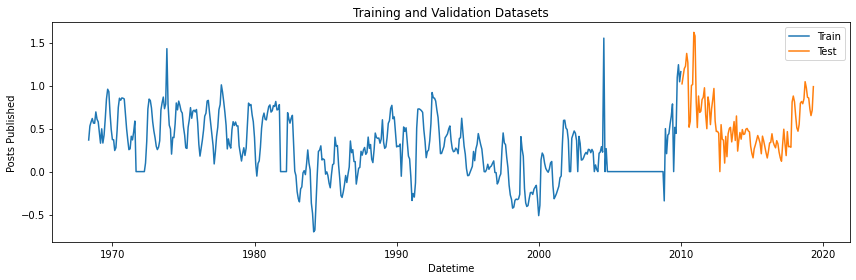

In [95]:
train = monthly.loc[:'2009-12-31']
valid = monthly.loc['2010-01-31':]
print(f'Shape: Train={train.shape}, Validation={valid.shape}')

# Plotting the training and validation datasets
plt.figure(figsize=(12, 4))
plt.plot(train, label='Train')
plt.plot(valid, label='Test')
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('Training and Validation Datasets')
plt.legend()
plt.tight_layout()
plt.show()

Indexing the train and test data into date form

In [96]:
train.index = pd.DatetimeIndex(train.index)
valid.index = pd.DatetimeIndex(valid.index)

In [97]:
# Visualizing the components of time series: Trend, Seasonality, and Noise
train.sort_index(inplace=True)
decomposition = sm.tsa.seasonal_decompose(train.dropna(), model = 'additive', period = int(len(train)/4))

Time series decomposition is a technique that splits a time series into several components, each representing an underlying pattern category,trend, seasonality and noise.

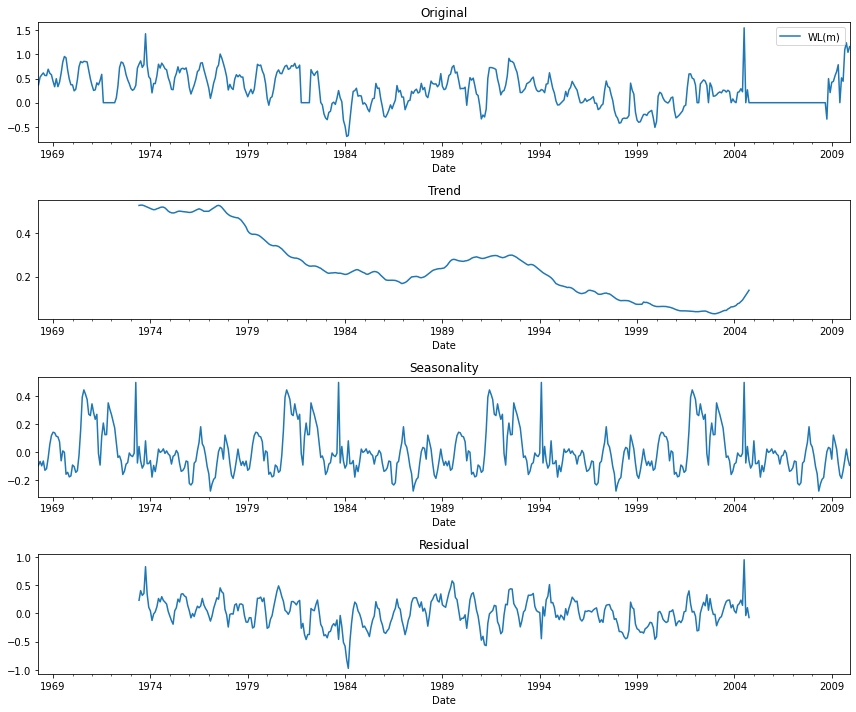

In [98]:
# Plotting the components
fig, axes = plt.subplots(4, 1, figsize=(12, 10)) 
train.plot(title='Original', ax=axes[0])
decomposition.trend.plot(title='Trend', ax=axes[1])
decomposition.seasonal.plot(title='Seasonality', ax=axes[2])
decomposition.resid.plot(title='Residual', ax=axes[3])
plt.tight_layout()
plt.show()

In [99]:
# Creating a function to plot the results of the forecast
def plot_forecast(forecast, model, rmse):
    plt.figure(figsize=(12,4))
    plt.plot(train.dropna(), label='Training')
    plt.plot(valid.dropna(), label='Actual')
    plt.plot(forecast, label='Forecast')
    plt.xlabel('Datetime')
    plt.ylabel('Posts Published')
    plt.title(f'{model} (RMSE: {round(rmse, 2)})')
    plt.legend()
    plt.tight_layout()
    plt.show()

Checking Seasonality of TS DATA
------------

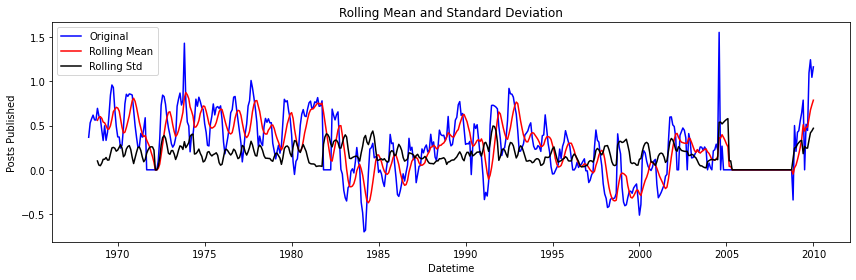

Results of Dickey-Fuller Test:
Test Statistic                  -2.500793
P-Value                          0.115281
#Lags Used                       9.000000
Number of Observations Used    491.000000
Critical Value (1%)             -3.443739
Critical Value (5%)             -2.867444
Critical Value (10%)            -2.569915
dtype: float64


In [100]:
# Creating a function to check stationarity of the train data
def check_stationarity(data):
    # Determining rolling statistics
    rol_mean = data.rolling(7).mean() #7 days in a week
    rol_std = data.rolling(7).std()
    
    # Plotting rolling statistics
    plt.figure(figsize=(12, 4))
    plt.plot(data, color='blue', label='Original')
    plt.plot(rol_mean, color='red', label='Rolling Mean')
    plt.plot(rol_std, color='black', label='Rolling Std')
    plt.xlabel('Datetime')
    plt.ylabel('Posts Published')
    plt.title('Rolling Mean and Standard Deviation')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Performing Dickey-Fuller test
    results = adfuller(data)
    df_output = pd.Series(results[:4], index=['Test Statistic', 'P-Value', '#Lags Used', 'Number of Observations Used'])
    for key, value in results[4].items():
        df_output[f'Critical Value ({key})'] = value
    print(f'Results of Dickey-Fuller Test:\n{df_output}')
    
# Stationarity check of our daily time series
check_stationarity(train)

###### As the test statistic is less than the critical values, we can say that the time series is already stationary. We can also see a trend in the visualization, therefore, we dont need to remove the trend and seasonality.

TIME SERIES MODELS
-----

ARIMA MODEL 

In [101]:
#MODEL implement and order set
arima = ARIMA(train, order=(7,1,1))

In [102]:
#model Fit
arima_model_fit = arima.fit()
# print summary of fit model
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  WL(m)   No. Observations:                  501
Model:                 ARIMA(7, 1, 1)   Log Likelihood                 171.183
Date:                Sun, 06 Nov 2022   AIC                           -324.366
Time:                        20:23:59   BIC                           -286.435
Sample:                    04-30-1968   HQIC                          -309.482
                         - 12-31-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3805      0.105      3.638      0.000       0.175       0.585
ar.L2          0.1096      0.058      1.891      0.059      -0.004       0.223
ar.L3         -0.1289      0.048     -2.660      0.0

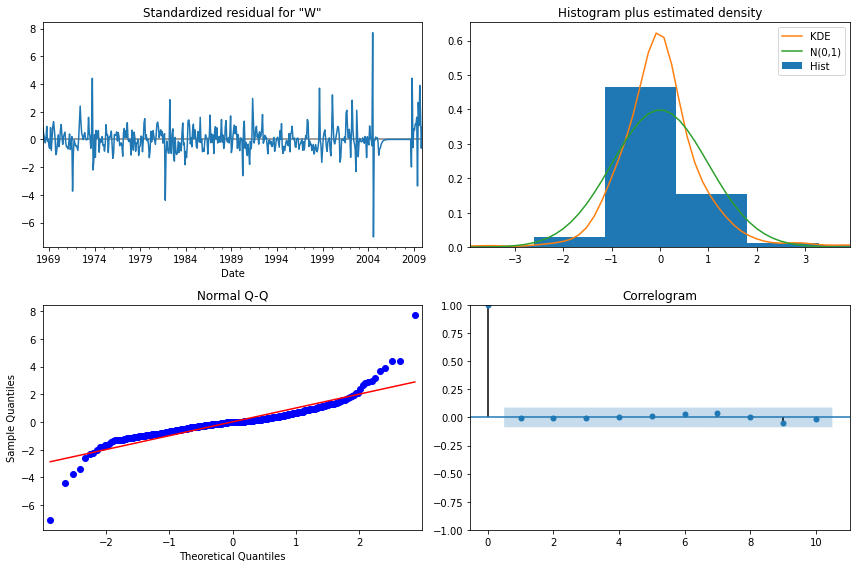

In [103]:
# Residual Plots
arima_model_fit.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

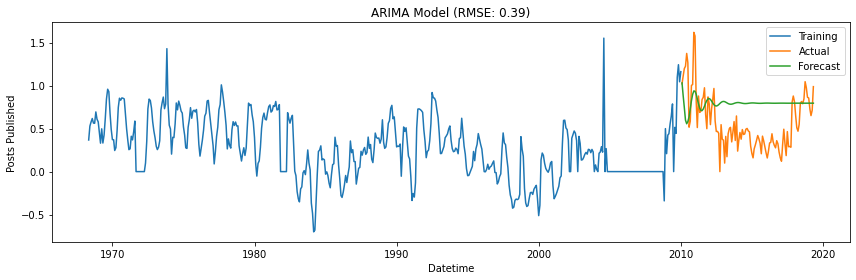

In [104]:
# Forecasting with the ARIMA model
forecast_arima = arima_model_fit.forecast(steps=len(valid))
arima_rmse = mean_squared_error(valid, forecast_arima, squared=False)
# # Plotting the ARIMA forecast
plot_forecast(forecast_arima, 'ARIMA Model', arima_rmse)

In [105]:
#Values of ARIMA prediction
print(forecast_arima)

2010-01-31    1.031691
2010-02-28    0.889822
2010-03-31    0.745587
2010-04-30    0.598358
2010-05-31    0.556571
                ...   
2018-12-31    0.796105
2019-01-31    0.796124
2019-02-28    0.796128
2019-03-31    0.796118
2019-04-30    0.796099
Freq: M, Name: predicted_mean, Length: 112, dtype: float64


In [106]:
arima_rmse  = mean_squared_error(valid, forecast_arima,squared=False)
print('Arima Root Mean Squared Error: ',arima_rmse)

Arima Root Mean Squared Error:  0.3944333356293804


---------------------

SARIMAX MODEL

In [107]:
#SARIMAX model order set
#(7,2,1, 12)
my_seasonal_order = (7,1,1, 12)
sarimax = SARIMAX(train, order=(7,1,1),seasonal_order=my_seasonal_order)

In [108]:
#Model fit
sarimax_model_fit = sarimax.fit()
# print summary of fit model
print(sarimax_model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                                     SARIMAX Results                                      
Dep. Variable:                              WL(m)   No. Observations:                  501
Model:             SARIMAX(7, 1, 1)x(7, 1, 1, 12)   Log Likelihood                 160.289
Date:                            Sun, 06 Nov 2022   AIC                           -286.578
Time:                                    20:26:27   BIC                           -215.342
Sample:                                04-30-1968   HQIC                          -258.596
                                     - 12-31-2009                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6704      0.047     14.202      0.000       0.578       0.763
ar.L2          0.1992      0.057   

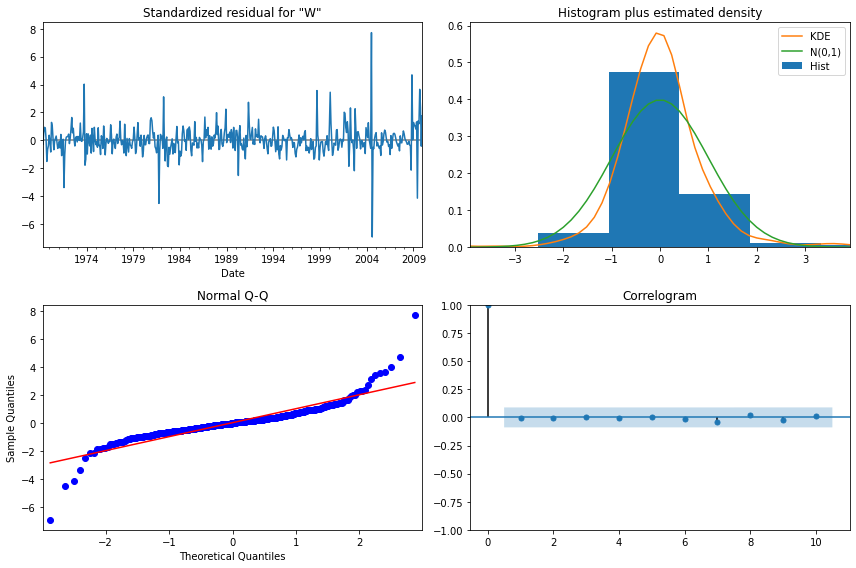

In [109]:
# Residual Plots
sarimax_model_fit.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

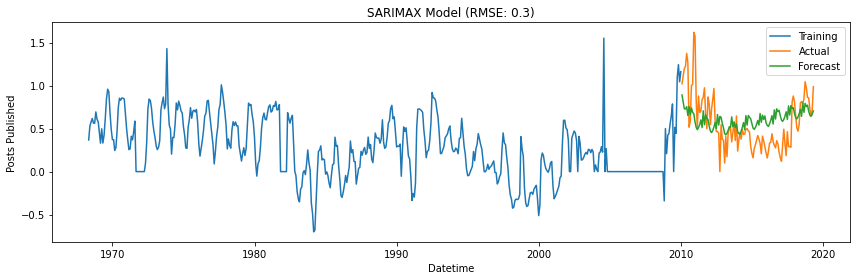

In [110]:
# Forecasting with the SARIMAX model
forecast_sarimax = sarimax_model_fit.forecast(steps=len(valid))
sarimax_rmse = mean_squared_error(valid, forecast_sarimax, squared=False)
# # Plotting the SARIMAX forecast
plot_forecast(forecast_sarimax, 'SARIMAX Model', sarimax_rmse)

In [111]:
#Value of SARIMA prediction
print(forecast_sarimax)

2010-01-31    0.891212
2010-02-28    0.815073
2010-03-31    0.731057
2010-04-30    0.728619
2010-05-31    0.755221
                ...   
2018-12-31    0.701771
2019-01-31    0.656684
2019-02-28    0.642598
2019-03-31    0.667203
2019-04-30    0.705826
Freq: M, Name: predicted_mean, Length: 112, dtype: float64


In [112]:
sarimax_rmse = mean_squared_error(valid, forecast_sarimax, squared=False)
print('Sarimax Root Mean Squared Error: ',sarimax_rmse)

Sarimax Root Mean Squared Error:  0.29736973740284023


-----------------------

PROPHET

In [113]:
#Reading monthly data 
df= pd.read_csv("Satkhira-Kholpetua_monthly.csv")

In [114]:
#renaming column for formatting prophet
df.columns = ['ds','y']
df.head()

,ds,y
0,1968-04-30,0.367667
1,1968-05-31,0.529677
2,1968-06-30,0.576500
3,1968-07-31,0.617742
4,1968-08-31,0.564355


In [115]:
#prophet model Implement
prophet_model = Prophet()

In [116]:
#Model fit
fit=prophet_model.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm_z0qnmg/1kjt95ug.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm_z0qnmg/weul4a26.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59401', 'data', 'file=/tmp/tmpm_z0qnmg/1kjt95ug.json', 'init=/tmp/tmpm_z0qnmg/weul4a26.json', 'output', 'file=/tmp/tmpm_z0qnmg/prophet_modell2wn1ru0/prophet_model-20221106202629.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:26:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [117]:
#forecasting the next 5 years monthly data
prophet_forecast_date = prophet_model.make_future_dataframe(periods=12 * 6, freq='M')
print(prophet_forecast_date)

            ds
0   1968-04-30
1   1968-05-31
2   1968-06-30
3   1968-07-31
4   1968-08-31
..         ...
680 2024-12-31
681 2025-01-31
682 2025-02-28
683 2025-03-31
684 2025-04-30

[685 rows x 1 columns]


In [118]:
#Prediting for the previous and next 5 years
prophet_prediction=prophet_model.predict(prophet_forecast_date)
prophet_prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1968-04-30,0.574037,0.102316,0.867286,0.574037,0.574037,-0.099171,-0.099171,-0.099171,-0.099171,-0.099171,-0.099171,0.0,0.0,0.0,0.474867
1,1968-05-31,0.572691,0.209690,0.955290,0.572691,0.572691,0.008823,0.008823,0.008823,0.008823,0.008823,0.008823,0.0,0.0,0.0,0.581514
2,1968-06-30,0.571387,0.265454,1.047429,0.571387,0.571387,0.096489,0.096489,0.096489,0.096489,0.096489,0.096489,0.0,0.0,0.0,0.667876
3,1968-07-31,0.570041,0.367818,1.112067,0.570041,0.570041,0.149030,0.149030,0.149030,0.149030,0.149030,0.149030,0.0,0.0,0.0,0.719070
4,1968-08-31,0.568694,0.325851,1.066228,0.568694,0.568694,0.137794,0.137794,0.137794,0.137794,0.137794,0.137794,0.0,0.0,0.0,0.706488


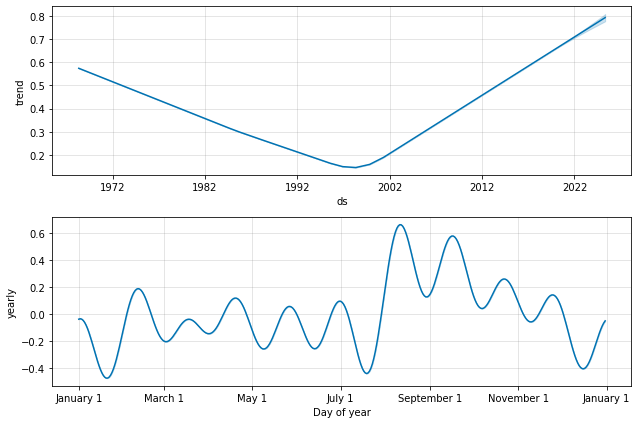

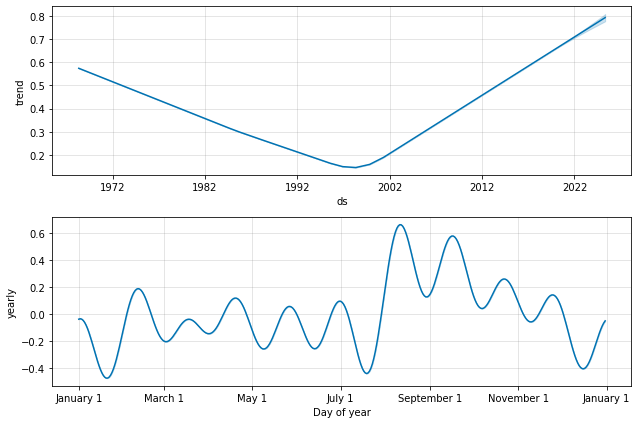

In [119]:
#### Visualize Each Components[Trends,yearly]
prophet_model.plot_components(prophet_prediction)

In [120]:
forecast_prophet_data=pd.DataFrame(prophet_prediction,columns=['ds','yhat'])
#setting the date as index of the dataframe 
fd=forecast_prophet_data.set_index('ds')
print(fd)

                yhat
ds                  
1968-04-30  0.474867
1968-05-31  0.581514
1968-06-30  0.667876
1968-07-31  0.719070
1968-08-31  0.706488
...              ...
2024-12-31  0.738426
2025-01-31  0.637052
2025-02-28  0.597590
2025-03-31  0.647994
2025-04-30  0.700882

[685 rows x 1 columns]


In [121]:
#converting the dataframe into series
full_forecast_prophet=fd['yhat'].squeeze()
print(full_forecast_prophet)

ds
1968-04-30    0.474867
1968-05-31    0.581514
1968-06-30    0.667876
1968-07-31    0.719070
1968-08-31    0.706488
                ...   
2024-12-31    0.738426
2025-01-31    0.637052
2025-02-28    0.597590
2025-03-31    0.647994
2025-04-30    0.700882
Name: yhat, Length: 685, dtype: float64


In [122]:
print(valid)

               WL(m)
Date                
2010-01-31  1.021129
2010-02-28  1.106786
2010-03-31  1.198548
2010-04-30  1.225833
2010-05-31  1.374677
...              ...
2018-12-31  0.856613
2019-01-31  0.727581
2019-02-28  0.651429
2019-03-31  0.714194
2019-04-30  0.988333

[112 rows x 1 columns]


In [123]:
forecast_prophet_valid=full_forecast_prophet['2010-01-31':'2019-04-30']

In [124]:
prophet_rmse = mean_squared_error(valid,forecast_prophet_valid, squared=False)
print('Prophet Root-mean-square error: ',prophet_rmse)

Prophet Root-mean-square error:  0.36525064585329864


-----------------

MODEL Comparison
----------

Testing

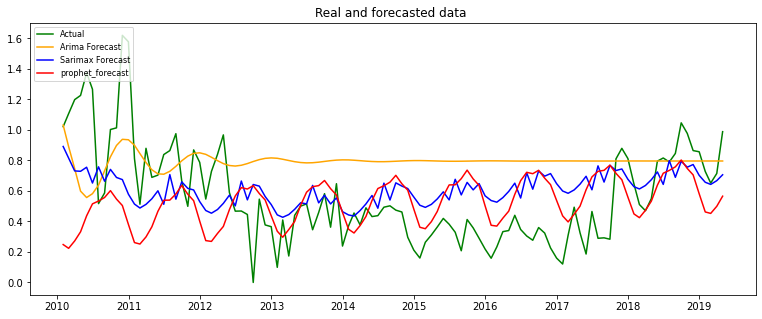

In [125]:
#comparing with test(actual) data
plt.figure(figsize=(13, 5))
# plot Testing and Forecasted data
plt.title("Real and forecasted data ")
plt.plot(valid, label='Actual', color='green')
plt.plot(forecast_arima, label='Arima Forecast', color='orange')
plt.plot(forecast_sarimax, label='Sarimax Forecast', color='blue')
plt.plot(forecast_prophet_valid, label='prophet_forecast', color='red')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Forecasting for 15 years since  2010 to 2025

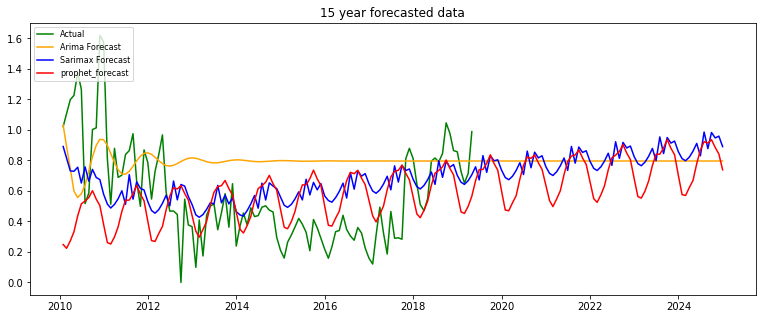

In [126]:
forecast_10_arima = arima_model_fit.forecast(steps=len(valid)+68)
forecast_10_sarima = sarimax_model_fit.forecast(steps=len(valid)+68)
forecast_10_prophet=full_forecast_prophet['2010-01-31':'2024-12-31']
plt.figure(figsize=(13, 5))
# plot Testing and Forecasted data
plt.title("15 year forecasted data")
plt.plot(valid, label='Actual', color='green')
plt.plot(forecast_10_arima, label='Arima Forecast', color='orange')
plt.plot(forecast_10_sarima, label='Sarimax Forecast', color='blue')
plt.plot(forecast_10_prophet, label='prophet_forecast', color='red')
plt.legend(loc='upper left', fontsize=8)
plt.show()

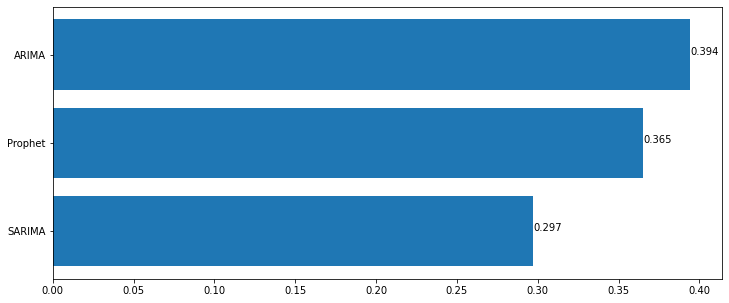

In [127]:
# Comparing Model Performances
plt.figure(figsize=(12, 5))
perf = pd.DataFrame({'Model': ['ARIMA', 'SARIMA', 'Prophet'],
                     'RMSE': [arima_rmse, sarimax_rmse, prophet_rmse]})
perf.sort_values('RMSE', inplace=True)
plt.barh(perf.Model, perf.RMSE)
 
for index,value in enumerate( perf.RMSE):
  final_value=round(value, 3)
  plt.text(value, index,str(final_value))
 
plt.show()

In [128]:
from datetime import date, datetime
print("--Enter the last date of the month between 2010 to 2024 to see the forecasted value--")
Date= (input('Enter a date in yyyy-mm-dd format :'))
print("")
if Date in forecast_10_arima.index or Date in forecast_10_sarima or Date in forecast_10_prophet:
  print("Great! Now choose the model result you want to see for",Date)
  model=int(input(' 1.Arima \n 2.Sarimax\n 3.Prophet\n '))
  if model==1:
    print("Choosen Model is Arima")
    print("In",Date,"rainfall value for Arima model: ",forecast_10_arima[Date])
  elif model==2:
    print("Choosen Model is Sarimax")
    print("In",Date,"rainfall value for Sarimax model: ",forecast_10_sarima[Date])
  elif model==3:
    print("Choosen Model is prophet")
    print("In",Date,"rainfall value for Prophet model: ",forecast_10_prophet[Date])
  else:
    print("choose among the three model")
else:
  print("Choose the correct date according to the mentioned format")


--Enter the last date of the month between 2010 to 2024 to see the forecasted value--
Enter a date in yyyy-mm-dd format :2013-03-31

Great! Now choose the model result you want to see for 2013-03-31
 1.Arima 
 2.Sarimax
 3.Prophet
 3
Choosen Model is prophet
In 2013-03-31 rainfall value for Prophet model:  0.34678588508062


In [129]:
merged=pd.concat([forecast_10_arima,forecast_10_sarima,forecast_10_prophet])
merged.to_csv("Satkhira-Kholpetua-monthly_merged.csv")